# Estimate the number of books that were borrowed

We know that the number of books included in the dataset decreases with each new book event added. If we fit a function to the surviving data, how well can we extrapolate to the missing data?

In [1]:
import pandas as pd
from datetime import datetime

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
csv_urls = {
    'members': '../recommender/data/SCoData_members_v1.1_2021-01.csv',
    'books': '../recommender/data/SCoData_books_v1.1_2021-01.csv',
    'events': '../recommender/data/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])

In [3]:
# Calculation from 2-book-activity.ipynb
MISSING_BOOK_EVENT_ESTIMATE = 0.2734

In [4]:
book_events = events_df[~events_df.item_uri.isna()].copy()
book_events['start_date'] = pd.to_datetime(book_events['start_date'], errors='coerce')
book_events = book_events.dropna(subset=['start_date'])
book_events = book_events[book_events['start_date'] < datetime(1942, 1, 1)]

/Users/kmcelwee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


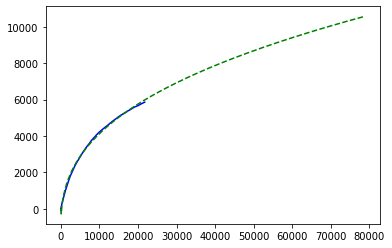

In [5]:
xs = []
ys = []

df_shuffle = book_events.sample(frac=1).copy()

# randomly shuffle rows when performing this analysis
for i in range(1, df_shuffle.shape[0], 50): 
    portion = df_shuffle.head(i)
    xs.append(i)
    ys.append(portion['item_uri'].unique().shape[0])


def approximate_function(x, a, b, c, d):
    return a * np.sqrt(b * x) + c*x**.25 + d*x**.125

xdata = xs
ydata = ys
plt.plot(xs, ys, 'b-', label='data')
popt, pcov = curve_fit(approximate_function, xdata, ydata)
 
x_pred = range(0, 79000, 100)
y_pred = [approximate_function(x, *popt) for x in x_pred]
plt.plot(x_pred, y_pred, 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

In [6]:
surviving_book_event_count = book_events.shape[0]
total_book_event_count = surviving_book_event_count / MISSING_BOOK_EVENT_ESTIMATE
surviving_book_count = books_df.shape[0]
total_book_count = approximate_function(total_book_event_count, *popt)

percent_surviving_books = round(surviving_book_count / total_book_count * 100, 2)
n_missing_books = total_book_count - surviving_book_count

print(f"Number of surviving book events: {surviving_book_event_count}")
print(f"Number of surviving books from book events: {surviving_book_count}")
print(f"Estimated number of book events [from calculation elsewhere]: {total_book_event_count}")
print(f"Estimated number of books from book events: {total_book_count}")
print(f"Estimated percent of books that survived {percent_surviving_books}")
print(f"Estimated number of missing books {n_missing_books}")

Number of surviving book events: 21767
Number of surviving books from book events: 6018
Estimated number of book events [from calculation elsewhere]: 79615.94732991954
Estimated number of books from book events: 10625.078910868579
Estimated percent of books that survived 56.64
Estimated number of missing books 4607.0789108685785
